# Notebook : Comparing the classic BKT with cheated BKT structure

In [1]:
import sys

sys.path.append("/Users/olivier/PycharmProjects/bayesian-kst/")
from kgraph.expert_layer.domain_graph import DomainGraph
from kgraph.expert_layer.knowledge_components import KnowledgeComponent, ProceduralKnowledgeComponent
from kgraph.expert_layer.links import LinkModel, LinkFromParents, LinkFromChildren
from kgraph.resources_layer.exercise_family import ExerciseFamily
from kgraph.resources_layer.exercise import Exercise
from kgraph.learner_layer.evaluation import Evaluation
from kgraph.learner_layer.learner_pool import LearnerPool
from kgraph.learner_layer.learner import Learner, LearnerGraph
from kgraph.helpers.truthtable import truthtable
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn

In [2]:
# we define the KCs
KC_A = ProceduralKnowledgeComponent(1, "A")
KC_B = ProceduralKnowledgeComponent(2, "B")

# we define the link between the two that gonna lead to the link model
link_a_to_b = LinkFromParents(KC_B, [KC_A], [.4, .6])
link_b_to_a = LinkFromChildren(KC_A, [KC_B], [.1, .9])
link_model = LinkModel([link_a_to_b, link_b_to_a])

In [3]:
# default params
params = {"slip": .1, "guess":.25}

# we define the exercises that corresponds to KC_A
ex_A_1 = Exercise(1, "qcm", ex_content="", params=params)
ex_A_2 = Exercise(2, "qcm", ex_content="", params=params)
ex_A_3 = Exercise(3, "qcm", ex_content="", params=params)
ex_A_4 = Exercise(4, "qcm", ex_content="", params=params)
ex_A_5 = Exercise(5, "qcm", ex_content="", params=params)

ex_fam_A = ExerciseFamily(1, "ex_fam_A", KC_A, [ex_A_1, ex_A_2, ex_A_3, ex_A_4, ex_A_5])

# we define the exercises that corresponds to KC_A
ex_B_1 = Exercise(6, "qcm", ex_content="", params=params)
ex_B_2 = Exercise(7, "qcm", ex_content="", params=params)
ex_B_3 = Exercise(8, "qcm", ex_content="", params=params)
ex_B_4 = Exercise(9, "qcm", ex_content="", params=params)
ex_B_5 = Exercise(10, "qcm", ex_content="", params=params)

ex_fam_B = ExerciseFamily(1, "ex_fam_B", KC_B, [ex_B_1, ex_B_2, ex_B_3, ex_B_4, ex_B_5])


In [4]:
# we create the associated domain graph
domain_graph = DomainGraph([KC_A, KC_B], link_model)

In [5]:
# we create a simulated learner to simulate with given mastering probability that corresponds to the model
learner_pool = LearnerPool(domain_graph)
simulated_test_learner = learner_pool.get_test_learner()

# P(A = 1) = .8
simulated_test_learner.set_mastering_probability(KC_A, .8)

# P(B = 1) = P(B=1|A=1)*P(A=1) + P(B=1|A=0)*P(A=0) = .6*.8 + .4*.2
simulated_test_learner.set_mastering_probability(KC_B, .56)

# print the learner graph of such a simulated learner
print(simulated_test_learner.learner_graph)

# we simulate an evaluation on exercise family associated to KC A
eval_a = simulated_test_learner.simulate_evaluation(ex_fam_A)
print(eval_a)

# we simulate an evaluation on exercise family associated to KC B
eval_b = simulated_test_learner.simulate_evaluation(ex_fam_B)
print(eval_b)

100%|██████████| 2/2 [00:00<00:00, 51463.85it/s]

LearnerGraph of Learner -1
P(1) = 0.8 (params: {'learn': 0.1, 'delta': -0.9, 'gamma': 2.2})
P(2) = 0.56 (params: {'learn': 0.1, 'delta': -0.9, 'gamma': 2.2})

Evaluation #0 on ExerciseFamily #1: 4/5
Evaluation #0 on ExerciseFamily #1: 4/5


## 1) Réalisation de l'exercice associé à KC A

In [6]:
# we extract common useful information about the evaluation on KC A
answers = eval_a.answers
evaluated_kc = eval_a.get_kc()

### Classic BKT
**Nodes** :
- for every KC for every step of the evaluation on an exercise family
- for every exercise result in the exercise family associated to the evaluation

**Links**:
- between evaluated KC nodes between successive temporalities 
- between evaluated KC and its parents/children for a same temporality
- between evaluated KC and exercise result node

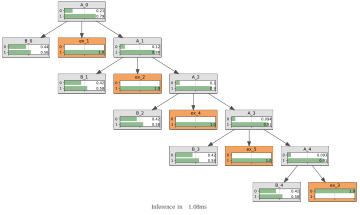

In [7]:
# we create a new blank learner that will do the evaluation and we observe the results of the mastering probability
blank_learner_bkt = learner_pool.get_test_learner()

# we initialize the network
bkt_net = gum.BayesNet('BKT')


# we setup every node
for i in range(len(eval_a.answers.keys())):
    for kc in domain_graph.get_knowledge_components():
        bkt_net.add(gum.LabelizedVariable(f"{kc.name}_{i}", '', 2))
    bkt_net.add(gum.LabelizedVariable(f"ex_{list(eval_a.answers)[i].id}", '', 2))
    
# we setup prior probabilities
prior_pba = blank_learner_bkt.get_mastering_probability(evaluated_kc)
bkt_net.cpt(f"{evaluated_kc.name}_0").fillWith([1 - prior_pba, prior_pba])
    
# we setup the links between layers
learn = blank_learner_bkt.get_learn_parameter(evaluated_kc)
for i in range(1, len(eval_a.answers.keys())):
    bkt_net.addArc(*(f"{evaluated_kc.name}_{i-1}", f"{evaluated_kc.name}_{i}"))
    bkt_net.cpt(f"{evaluated_kc.name}_{i}")[{f"{evaluated_kc.name}_{i-1}": False}] = [1-learn, learn]
    bkt_net.cpt(f"{evaluated_kc.name}_{i}")[{f"{evaluated_kc.name}_{i-1}": True}] = [0, 1]
    
# we setup the links inside every layer
eval_kc_parents = domain_graph.link_model.get_parents(evaluated_kc)
eval_kc_children = domain_graph.link_model.get_children(evaluated_kc)

for i in range(len(eval_a.answers.keys())):
    for parent in eval_kc_parents:
        print(parent.name)
        parent_children = domain_graph.link_model.get_children(parent)
        for child in parent_children:
            bkt_net.addArc(*(f"{child.name}_{i}", f"{parent.name}_{i}"))

        print([kc.name for kc in parent_children])
        tt_parent = truthtable(len(parent_children))
        cond_vec = domain_graph.link_model.get_links(parent)["from_children"].probability_vector
        for j in range(len(tt_parent)):
            print({f"{parent_children[k]}_{i}": tt_parent[j][k] for k in range(len(parent_children))})
            bkt_net.cpt(f"{parent.name}_{i}")[{f"{parent_children[k].name}_{i}": tt_parent[j][k] 
                                               for k in range(len(parent_children))}] = [
                1-cond_vec[j], cond_vec[j]]
        
    for child in eval_kc_children:
        child_parents = domain_graph.link_model.get_parents(child)
        for parent in child_parents:
            bkt_net.addArc(*(f"{parent.name}_{i}", f"{child.name}_{i}"))
        tt_child = truthtable(len(child_parents))
        cond_vec = domain_graph.link_model.get_links(child)["from_parents"].probability_vector
        for j in range(len(tt_child)):
            bkt_net.cpt(f"{child.name}_{i}")[{f"{child_parents[k].name}_{i}": tt_child[j][k] 
                                              for k in range(len(child_parents))}] = [
                1-cond_vec[j], cond_vec[j]]

    bkt_net.addArc(*(f"{evaluated_kc.name}_{i}", f"ex_{list(eval_a.answers)[i].id}"))
    guess, slip = list(eval_a.answers)[i].get_guess(), list(eval_a.answers)[i].get_slip()
    bkt_net.cpt(f"ex_{list(eval_a.answers)[i].id}")[{f"{evaluated_kc.name}_{i}": False}] = [1-guess, guess]
    bkt_net.cpt(f"ex_{list(eval_a.answers)[i].id}")[{f"{evaluated_kc.name}_{i}": True}] = [slip, 1-slip]

evidences = {f'ex_{key.id}': int(eval_a.answers[key]["success"]) for key in eval_a.answers.keys()}
gnb.showInference(bkt_net, evs=evidences)

In [8]:
bkt_net

(gum::BayesNet<double>@0x115a9f000) BN{nodes: 15, arcs: 14, domainSize: 32768, dim: 58}

### Cheated BKT network V1 
**Nodes** :
- for every KC before and after the evaluation
- for the evaluation

**Links**:
- for every KC, between same KC nodes between successive temporalities
- for every temporality but the first one, between evaluated KC and its parents/children for a same temporality.

#### Initial layer
![eval layers](img/initial_layer_v1.png)

#### Eval layer
![eval layers](img/cheated_bkt_net_v1.png)

In [9]:
### STRUCTURE
# we create a new blank learner that will do the evaluation and we observe the results of the mastering probability
blank_learner_v1_cheated_bkt = learner_pool.get_test_learner()
evals = [eval_a] 
# we initialize the network
v1_cheated_bkt_net = gum.BayesNet('Cheated BKT V1')

# we assume there is an external algorithm that compute the updated probability for a given evaluation
prior_pba = blank_learner_v1_cheated_bkt.get_mastering_probability(evaluated_kc)
blank_learner_v1_cheated_bkt.process_evaluation(eval_a)
updated_pba = blank_learner_v1_cheated_bkt.get_mastering_probability(evaluated_kc)

knowledge_components = domain_graph.get_knowledge_components()
steps = ["init"] + [f'eval_{ev.id}' for ev in evals] + ["final"]

# we setup the initial layer
for kc in knowledge_components:
    v1_cheated_bkt_net.add(gum.LabelizedVariable(f"{kc.name}_init", '', 2))
    
# we setup the final layer
for kc in domain_graph.get_knowledge_components():
    v1_cheated_bkt_net.add(gum.LabelizedVariable(f"{kc.name}_final", '', 2))

# we setup the evaluation layers
for eval_step in [x for x in steps if x.startswith('eval')]:
    for kc in domain_graph.get_knowledge_components():
        v1_cheated_bkt_net.add(gum.LabelizedVariable(f"{kc.name}_"+eval_step, '', 2))
    v1_cheated_bkt_net.add(gum.LabelizedVariable(eval_step, '', 2))
    
    
# we setup the links inbetween layer  
for kc in knowledge_components:
    for i in range(1, len(steps)):
        v1_cheated_bkt_net.addArc(*(f"{kc.name}_"+steps[i-1], f"{kc.name}_"+steps[i]))
        


# we setup the links inside a common layer

for eval_step in [x for x in steps if x.startswith('eval')]:
    for kc in knowledge_components:
        parents = domain_graph.link_model.get_parents(kc)
        for parent in parents:
            v1_cheated_bkt_net.addArc(*(f"{parent.name}_"+eval_step, f"{kc.name}_"+eval_step))
    v1_cheated_bkt_net.addArc(*(eval_step, f"{evaluated_kc.name}_"+eval_step))
            
v1_cheated_bkt_net

(gum::BayesNet<double>@0x115aa5c00) BN{nodes: 7, arcs: 6, domainSize: 128, dim: 30}

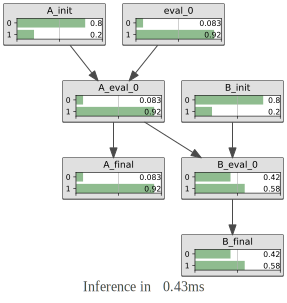

In [10]:
### VALUES
# we setup the values of the conditional probabilities that rule the network

# initial layer consists in prior probabilities
for kc in knowledge_components:
    if kc is evaluated_kc:
        v1_cheated_bkt_net.cpt(f"{kc.name}_init").fillWith([1 - prior_pba, prior_pba])
    else:
        kc_m_pba = blank_learner_v1_cheated_bkt.get_mastering_probability(kc)
        v1_cheated_bkt_net.cpt(f"{kc.name}_init").fillWith([1 - kc_m_pba, kc_m_pba])

# final layer only depends on the n-1th layer
for kc in knowledge_components:
    v1_cheated_bkt_net.cpt(f"{kc.name}_"+steps[-1])[{f"{kc.name}_"+steps[-2]: False}] = [1, 0]
    v1_cheated_bkt_net.cpt(f"{kc.name}_"+steps[-1])[{f"{kc.name}_"+steps[-2]: True}] = [0, 1]

    
# eval node on eval layers
for eval_step in [x for x in steps if x.startswith('eval')]:
    v1_cheated_bkt_net.cpt(eval_step).fillWith([1 - updated_pba, updated_pba])

# evaluated kc node on eval layers
for eval_step in [x for x in steps if x.startswith('eval')]:
    for kc in knowledge_components:
        if kc is evaluated_kc:  # we suppose that the info contained in an evaluation is stronger than prior info
            v1_cheated_bkt_net.cpt(f"{kc.name}_"+eval_step)[{eval_step: False,
                                                                       f"{kc.name}_init": False}] = [1, 0]
            v1_cheated_bkt_net.cpt(f"{kc.name}_"+eval_step)[{eval_step: False,
                                                                       f"{kc.name}_init": True}] = [1, 0]
            v1_cheated_bkt_net.cpt(f"{kc.name}_"+eval_step)[{eval_step: True,
                                                                       f"{kc.name}_init": False}] = [0, 1]
            v1_cheated_bkt_net.cpt(f"{kc.name}_"+eval_step)[{eval_step: True,
                                                                       f"{kc.name}_init": True}] = [0, 1]
        else:
            parents = domain_graph.link_model.get_parents(kc)
            tt_parents = truthtable(len(parents))
            cond_vec = domain_graph.link_model.get_links(kc)["from_parents"].probability_vector
            for j in range(len(tt_parents)):
                v1_cheated_bkt_net.cpt(f"{kc.name}_"+eval_step)[{
                    **{f"{kc.name}_init": False},
                    **{f"{parents[k].name}_"+eval_step: tt_parents[j][k] for k in range(len(parents))}}] = [
                    1 - cond_vec[j], cond_vec[j]]
                v1_cheated_bkt_net.cpt(f"{kc.name}_"+eval_step)[{
                    **{f"{kc.name}_init": True},
                    **{f"{parents[k].name}_"+eval_step: tt_parents[j][k] for k in range(len(parents))}}] = [
                    1 - cond_vec[j], cond_vec[j]]

gnb.showInference(v1_cheated_bkt_net, evs={})

### Cheated BKT network V2
**Nodes** :
- for every KC before and after the evaluation
- for the evaluation

**Links**:
- for every KC, between same KC nodes between successive temporalities
- for every KC, between KC and its parents/children for successive temporalities. We can discuss the spread of the links (evaluated KC to children of every evaluated KC child, etc)

#### Initial layer
![eval layers](img/initial_layer_v1.png)

#### Eval layer
![eval layers](img/cheated_bkt_net_v2.png)

In [11]:
# we create a new blank learner that will do the evaluation and we observe the results of the mastering probability
blank_learner_v2_cheated_bkt = learner_pool.get_test_learner()
evals = [eval_a] 
# we initialize the network
v2_cheated_bkt_net = gum.BayesNet('Cheated BKT V2')

# we assume there is an external algorithm that compute the updated probability for a given evaluation
prior_pba = blank_learner_v2_cheated_bkt.get_mastering_probability(evaluated_kc)
blank_learner_v2_cheated_bkt.process_evaluation(eval_a)
updated_pba = blank_learner_v2_cheated_bkt.get_mastering_probability(evaluated_kc)

knowledge_components = domain_graph.get_knowledge_components()
steps = ["init"] + [f'eval_{ev.id}' for ev in evals] + ["final"]

# we setup the initial layer
for kc in knowledge_components:
    v2_cheated_bkt_net.add(gum.LabelizedVariable(f"{kc.name}_init", '', 2))
    
# we setup the final layer
for kc in domain_graph.get_knowledge_components():
    v2_cheated_bkt_net.add(gum.LabelizedVariable(f"{kc.name}_final", '', 2))

# we setup the evaluation layers
for eval_step in [x for x in steps if x.startswith('eval')]:
    for kc in domain_graph.get_knowledge_components():
        v2_cheated_bkt_net.add(gum.LabelizedVariable(f"{kc.name}_"+eval_step, '', 2))
    v2_cheated_bkt_net.add(gum.LabelizedVariable(eval_step, '', 2))
    
    
# we setup the links inbetween layer  
for kc in knowledge_components:
    for i in range(1, len(steps)):
        v2_cheated_bkt_net.addArc(*(f"{kc.name}_"+steps[i-1], f"{kc.name}_"+steps[i]))
        parents = domain_graph.link_model.get_parents(kc)
        for parent in parents:
            v2_cheated_bkt_net.addArc(*(f"{kc.name}_"+steps[i-1], f"{parent.name}_"+steps[i]))
        children = domain_graph.link_model.get_children(kc)
        for child in children:
            v2_cheated_bkt_net.addArc(*(f"{kc.name}_"+steps[i-1], f"{child.name}_"+steps[i]))



# we setup the links inside a common layer

for eval_step in [x for x in steps if x.startswith('eval')]:
    v2_cheated_bkt_net.addArc(*(eval_step, f"{evaluated_kc.name}_"+eval_step))
            
v2_cheated_bkt_net        

(gum::BayesNet<double>@0x135a62600) BN{nodes: 7, arcs: 9, domainSize: 128, dim: 46}

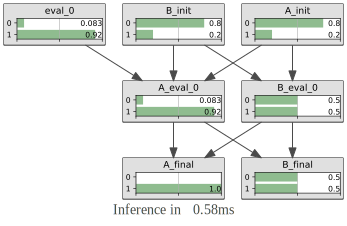

In [12]:
### VALUES
# we setup the values of the conditional probabilities that rule the network

# initial layer consists in prior probabilities
for kc in knowledge_components:
    if kc is evaluated_kc:
        v2_cheated_bkt_net.cpt(f"{kc.name}_init").fillWith([1 - prior_pba, prior_pba])
    else:
        kc_m_pba = blank_learner_v2_cheated_bkt.get_mastering_probability(kc)
        v2_cheated_bkt_net.cpt(f"{kc.name}_init").fillWith([1 - kc_m_pba, kc_m_pba])

for eval_step in [x for x in steps if x.startswith('eval')]:
    v2_cheated_bkt_net.cpt(eval_step).fillWith([1 - updated_pba, updated_pba])


# final layer only depends on the n-1th layer
for kc in knowledge_components:
    for i in range(1, len(steps)):
        if kc is evaluated_kc:
            parents = domain_graph.link_model.get_parents(kc)
            tt_parents = truthtable(len(parents))
            children = domain_graph.link_model.get_children(kc)
            tt_children = truthtable(len(children))
            for k in range(len(tt_parents)):
                for l in range(len(tt_children)):
                    v2_cheated_bkt_net.cpt(f"{kc.name}_"+steps[i])[{
                        **{f"{steps[i]}": False},
                        **{f"{kc.name}_"+steps[i-1]: False},
                        **{f"{parents[j].name}_"+steps[i-1]: tt_parents[k][j] for j in range(len(parents))},
                        **{f"{children[j].name}_"+steps[i-1]: tt_children[l][j] for j in range(len(children))}}] = [
                        1, 0
                    ]
                    v2_cheated_bkt_net.cpt(f"{kc.name}_"+steps[i])[{
                        **{f"{steps[i]}": False},
                        **{f"{kc.name}_"+steps[i-1]: True},
                        **{f"{parents[j].name}_"+steps[i-1]: tt_parents[k][j] for j in range(len(parents))},
                        **{f"{children[j].name}_"+steps[i-1]: tt_children[l][j] for j in range(len(children))}}] = [
                        1, 0
                    ]
                    v2_cheated_bkt_net.cpt(f"{kc.name}_"+steps[i])[{
                        **{f"{steps[i]}": True},
                        **{f"{kc.name}_"+steps[i-1]: False},
                        **{f"{parents[j].name}_"+steps[i-1]: tt_parents[k][j] for j in range(len(parents))},
                        **{f"{children[j].name}_"+steps[i-1]: tt_children[l][j] for j in range(len(children))}}] = [
                        0, 1
                    ]
                    v2_cheated_bkt_net.cpt(f"{kc.name}_"+steps[i])[{
                        **{f"{steps[i]}": True},
                        **{f"{kc.name}_"+steps[i-1]: True},
                        **{f"{parents[j].name}_"+steps[i-1]: tt_parents[k][j] for j in range(len(parents))},
                        **{f"{children[j].name}_"+steps[i-1]: tt_children[l][j] for j in range(len(children))}}] = [
                        0, 1
                    ]
        else:
            parents = domain_graph.link_model.get_parents(kc)
            tt_parents = truthtable(len(parents))
            children = domain_graph.link_model.get_children(kc)
            tt_children = truthtable(len(children))
            for k in range(len(tt_parents)):
                for l in range(len(tt_children)):
                    #cond_val = get_conditional_probability_between_time(kc, )
                    v2_cheated_bkt_net.cpt(f"{kc.name}_"+steps[i])[{
                        **{f"{kc.name}_"+steps[i-1]: False},
                        **{f"{parents[j].name}_"+steps[i-1]: tt_parents[k][j] for j in range(len(parents))},
                        **{f"{children[j].name}_"+steps[i-1]: tt_children[l][j] for j in range(len(children))}}] = [
                        .5, .5
                    ]
                    v2_cheated_bkt_net.cpt(f"{kc.name}_"+steps[i])[{
                        **{f"{kc.name}_"+steps[i-1]: True},
                        **{f"{parents[j].name}_"+steps[i-1]: tt_parents[k][j] for j in range(len(parents))},
                        **{f"{children[j].name}_"+steps[i-1]: tt_children[l][j] for j in range(len(children))}}] = [
                        .5, .5
                    ]

    
gnb.showInference(v2_cheated_bkt_net, evs={})

### Cheated BKT network V3
**Nodes** :
- for every KC before and after the evaluation
- for the evaluation

**Links**:
- for every KC, between same KC nodes between successive temporalities
- for every KC, between KC and either its parents or its children for successive temporalities.

#### Initial layer
![eval layers](img/initial_layer_v1.png)

#### Eval layer
![eval layers](img/cheated_bkt_net_v3.png)

In [13]:
# we create a new blank learner that will do the evaluation and we observe the results of the mastering probability
blank_learner_v3_cheated_bkt = learner_pool.get_test_learner()
evals = [eval_a] 
# we initialize the network
v3_cheated_bkt_net = gum.BayesNet('Cheated BKT V3')


# we assume there is an external algorithm that compute the updated probability for a given evaluation
prior_pba = blank_learner_v3_cheated_bkt.get_mastering_probability(evaluated_kc)
blank_learner_v3_cheated_bkt.process_evaluation(eval_a)
updated_pba = blank_learner_v3_cheated_bkt.get_mastering_probability(evaluated_kc)

knowledge_components = domain_graph.get_knowledge_components()
steps = ["init"] + [f'eval_{ev.id}' for ev in evals] + ["final"]

# we setup the initial layer
for kc in knowledge_components:
    v3_cheated_bkt_net.add(gum.LabelizedVariable(f"{kc.name}_init", '', 2))
    
# we setup the final layer
for kc in domain_graph.get_knowledge_components():
    v3_cheated_bkt_net.add(gum.LabelizedVariable(f"{kc.name}_final", '', 2))

# we setup the evaluation layers
for eval_step in [x for x in steps if x.startswith('eval')]:
    for kc in domain_graph.get_knowledge_components():
        v3_cheated_bkt_net.add(gum.LabelizedVariable(f"{kc.name}_"+eval_step, '', 2))
    v3_cheated_bkt_net.add(gum.LabelizedVariable(eval_step, '', 2))
    
    
# we setup the links inbetween layer  
choice = 'children'  # input("children or parents?")
for kc in knowledge_components:
    for i in range(1, len(steps)):
        v3_cheated_bkt_net.addArc(*(f"{kc.name}_"+steps[i-1], f"{kc.name}_"+steps[i]))
        if choice == 'children':
            children = domain_graph.link_model.get_children(kc)
            for child in children:
                v3_cheated_bkt_net.addArc(*(f"{kc.name}_"+steps[i-1], f"{child.name}_"+steps[i]))
        elif choice == 'parents':
            parents = domain_graph.link_model.get_parents(kc)
            for parent in parents:
                v3_cheated_bkt_net.addArc(*(f"{kc.name}_"+steps[i-1], f"{parent.name}_"+steps[i]))

# we setup the links inside a common layer

for eval_step in [x for x in steps if x.startswith('eval')]:
    v3_cheated_bkt_net.addArc(*(eval_step, f"{evaluated_kc.name}_"+eval_step))
            
v3_cheated_bkt_net        

(gum::BayesNet<double>@0x115aa3800) BN{nodes: 7, arcs: 7, domainSize: 128, dim: 34}

### Cheated BKT network V4
**Nodes** :
- for every KC before and after the evaluation
- for the evaluation

**Links**:
- for every KC, between same KC nodes between successive temporalities
- for evaluated KC, between the evaluation and all parents/children KCs of the evaluated KC.

#### Initial layer
![eval layers](img/initial_layer_v1.png)

#### Eval layer
![eval layers](img/cheated_bkt_net_v4.png)

In [14]:
# we create a new blank learner that will do the evaluation and we observe the results of the mastering probability
blank_learner_v4_cheated_bkt = learner_pool.get_test_learner()
evals = [eval_a] 
# we initialize the network
v4_cheated_bkt_net = gum.BayesNet('Cheated BKT V2')

# we assume there is an external algorithm that compute the updated probability for a given evaluation
prior_pba = blank_learner_v4_cheated_bkt.get_mastering_probability(evaluated_kc)
blank_learner_v4_cheated_bkt.process_evaluation(eval_a)
updated_pba = blank_learner_v4_cheated_bkt.get_mastering_probability(evaluated_kc)

knowledge_components = domain_graph.get_knowledge_components()
steps = ["init"] + [f'eval_{ev.id}' for ev in evals] + ["final"]

# we setup the initial layer
for kc in knowledge_components:
    v4_cheated_bkt_net.add(gum.LabelizedVariable(f"{kc.name}_init", '', 2))
    
# we setup the final layer
for kc in domain_graph.get_knowledge_components():
    v4_cheated_bkt_net.add(gum.LabelizedVariable(f"{kc.name}_final", '', 2))

# we setup the evaluation layers
for eval_step in [x for x in steps if x.startswith('eval')]:
    for kc in domain_graph.get_knowledge_components():
        v4_cheated_bkt_net.add(gum.LabelizedVariable(f"{kc.name}_"+eval_step, '', 2))
    v4_cheated_bkt_net.add(gum.LabelizedVariable(eval_step, '', 2))
    
    
# we setup the links inbetween layer  
for kc in knowledge_components:
    for i in range(1, len(steps)):
        v4_cheated_bkt_net.addArc(*(f"{kc.name}_"+steps[i-1], f"{kc.name}_"+steps[i]))


# we setup the links inside a common layer
for eval_step in [x for x in steps if x.startswith('eval')]:
    v4_cheated_bkt_net.addArc(*(eval_step, f"{evaluated_kc.name}_"+eval_step))
    all_children = domain_graph.link_model.get_all_children(evaluated_kc)
    print("children", [kc.name for kc in all_children])
    for child in all_children:
        v4_cheated_bkt_net.addArc(*(eval_step, f"{child.name}_"+eval_step))
    all_parents = domain_graph.link_model.get_all_parents(evaluated_kc)
    print("parents", [kc.name for kc in all_parents])
    for parent in all_parents:
        v4_cheated_bkt_net.addArc(*(eval_step, f"{parent.name}_"+eval_step))

    
            
v4_cheated_bkt_net        

children ['B']
parents []


(gum::BayesNet<double>@0x1408ef600) BN{nodes: 7, arcs: 6, domainSize: 128, dim: 30}

## 2) Réalisation de l'exercice associé à KC B

### Classic BKT V1

In [15]:
v1_bkt_net = gum.BayesNet('BKT')
learn = 0.1
evs = {}
for i in range(len(answers.keys())):
    guess, slip = .25, .1
    v1_bkt_net.add(gum.LabelizedVariable(f"KCA_{i}", '', 2))
    v1_bkt_net.add(gum.LabelizedVariable(f"KCB_{i}", '', 2))
    v1_bkt_net.addArc(*(f"KCA_{i}", f"KCB_{i}"))

    v1_bkt_net.add(gum.LabelizedVariable(f"EXB_{i}", '', 2))
    v1_bkt_net.addArc(*(f"KCB_{i}", f"EXB_{i}"))
    v1_bkt_net.cpt(f"EXB_{i}")[{f"KCB_{i}": False}] = [1-guess, guess]
    v1_bkt_net.cpt(f"EXB_{i}")[{f"KCB_{i}": True}] = [slip, 1-slip]
    evs[f"EXB_{i}"] = int(answers[f"ex_{i+1}"]["success"])
    if i != 0:
        v1_bkt_net.addArc(*(f"KCB_{i-1}", f"KCB_{i}"))
        v1_bkt_net.cpt(f"KCB_{i}")[{f"KCB_{i-1}": False, f"KCA_{i}": False}] = [1-learn*.01, learn*.01]
        v1_bkt_net.cpt(f"KCB_{i}")[{f"KCB_{i-1}": False, f"KCA_{i}": True}] = [1-learn*.5, learn*.5]
        v1_bkt_net.cpt(f"KCB_{i}")[{f"KCB_{i-1}": True, f"KCA_{i}": False}] = [.99, .01]
        v1_bkt_net.cpt(f"KCB_{i}")[{f"KCB_{i-1}": True, f"KCA_{i}": True}] = [0, 1]
    else:
        v1_bkt_net.cpt(f"KCB_0")[{f"KCA_0": True}] = [.5, .5]
        v1_bkt_net.cpt(f"KCB_0")[{f"KCA_0": False}] = [.99, .01]    



v1_bkt_net.cpt(f"KCA_0").fillWith([.5, .5])
v1_bkt_net.cpt(f"KCA_1").fillWith([.5, .5])
v1_bkt_net.cpt(f"KCA_2").fillWith([.5, .5])

gnb.showInference(v1_bkt_net, evs=evs)

KeyError: 'ex_1'

### Classic BKT V2

In [ ]:
v2_bkt_net = gum.BayesNet('BKT')
learn = 0.1
evs = {}
for i in range(len(answers.keys())):
    guess, slip = .25, .1
    v2_bkt_net.add(gum.LabelizedVariable(f"KCA_{i}", '', 2))
    v2_bkt_net.add(gum.LabelizedVariable(f"KCB_{i}", '', 2))
    v2_bkt_net.addArc(*(f"KCA_{i}", f"KCB_{i}"))

    v2_bkt_net.add(gum.LabelizedVariable(f"EXB_{i}", '', 2))
    v2_bkt_net.addArc(*(f"KCB_{i}", f"EXB_{i}"))
    v2_bkt_net.cpt(f"EXB_{i}")[{f"KCB_{i}": False}] = [1-guess, guess]
    v2_bkt_net.cpt(f"EXB_{i}")[{f"KCB_{i}": True}] = [slip, 1-slip]
    evs[f"EXB_{i}"] = int(answers[f"ex_{i+1}"]["success"])
    if i != 0:
        v2_bkt_net.addArc(*(f"KCA_{i-1}", f"KCA_{i}"))
        v2_bkt_net.cpt(f"KCA_{i}")[{f"KCA_{i-1}": False}] = [1, 0]
        v2_bkt_net.cpt(f"KCA_{i}")[{f"KCA_{i-1}": True}] = [0, 1]

        v2_bkt_net.addArc(*(f"KCB_{i-1}", f"KCB_{i}"))
        v2_bkt_net.cpt(f"KCB_{i}")[{f"KCB_{i-1}": False, f"KCA_{i}": False}] = [1-learn*.01, learn*.01]
        v2_bkt_net.cpt(f"KCB_{i}")[{f"KCB_{i-1}": False, f"KCA_{i}": True}] = [1-learn*.5, learn*.5]
        v2_bkt_net.cpt(f"KCB_{i}")[{f"KCB_{i-1}": True, f"KCA_{i}": False}] = [.99, .01]
        v2_bkt_net.cpt(f"KCB_{i}")[{f"KCB_{i-1}": True, f"KCA_{i}": True}] = [0, 1]
    else:
        v2_bkt_net.cpt(f"KCB_{i}")[{f"KCA_{i}": True}] = [.5, .5]
        v2_bkt_net.cpt(f"KCB_{i}")[{f"KCA_{i}": False}] = [.99, .01]    
        v2_bkt_net.cpt(f"KCA_{i}").fillWith([.5, .5])

gnb.showInference(v2_bkt_net, evs=evs)

### Classic BKT V3

In [ ]:
v3_bkt_net = gum.BayesNet('BKT')
learn = 0.1
evs = {}
for i in range(len(answers.keys())):
    guess, slip = .25, .1
    v3_bkt_net.add(gum.LabelizedVariable(f"KCA_{i}", '', 2))
    v3_bkt_net.add(gum.LabelizedVariable(f"KCB_{i}", '', 2))

    v3_bkt_net.add(gum.LabelizedVariable(f"EXB_{i}", '', 2))
    v3_bkt_net.addArc(*(f"KCB_{i}", f"EXB_{i}"))
    v3_bkt_net.cpt(f"EXB_{i}")[{f"KCB_{i}": False}] = [1-guess, guess]
    v3_bkt_net.cpt(f"EXB_{i}")[{f"KCB_{i}": True}] = [slip, 1-slip]
    evs[f"EXB_{i}"] = int(answers[f"ex_{i+1}"]["success"])
    if i != 0:
        v3_bkt_net.addArc(*(f"KCB_{i}", f"KCA_{i}"))

        v3_bkt_net.addArc(*(f"KCB_{i-1}", f"KCB_{i}"))
        v3_bkt_net.cpt(f"KCB_{i}")[{f"KCB_{i-1}": False}] = [1-learn, learn]
        v3_bkt_net.cpt(f"KCB_{i}")[{f"KCB_{i-1}": True}] = [0, 1]
        
        v3_bkt_net.cpt(f"KCA_{i}")[{f"KCA_{i-1}": False, f"KCB_{i}": False}] = [1, 0]
        v3_bkt_net.cpt(f"KCA_{i}")[{f"KCA_{i-1}": False, f"KCB_{i}": True}] = [.01, .99]
        v3_bkt_net.cpt(f"KCA_{i}")[{f"KCA_{i-1}": True, f"KCB_{i}": False}] = [.5, .5]
        v3_bkt_net.cpt(f"KCA_{i}")[{f"KCA_{i-1}": True, f"KCB_{i}": True}] = [0, 1]

    else:
        v3_bkt_net.addArc(*(f"KCA_{i}", f"KCB_{i}"))
        v3_bkt_net.cpt(f"KCB_{i}")[{f"KCA_{i}": True}] = [.5, .5]
        v3_bkt_net.cpt(f"KCB_{i}")[{f"KCA_{i}": False}] = [.99, .01]    
        v3_bkt_net.cpt(f"KCA_{i}").fillWith([.5, .5])

gnb.showInference(v3_bkt_net, evs=evs)

### Classic BKT V4

In [ ]:
v4_bkt_net = gum.BayesNet('BKT')
learn = 0.1
evs = {}
for i in range(len(answers.keys())):
    guess, slip = .25, .1
    v4_bkt_net.add(gum.LabelizedVariable(f"KCA_{i}", '', 2))
    v4_bkt_net.add(gum.LabelizedVariable(f"KCB_{i}", '', 2))

    v4_bkt_net.add(gum.LabelizedVariable(f"EXB_{i}", '', 2))
    v4_bkt_net.addArc(*(f"KCB_{i}", f"EXB_{i}"))
    v4_bkt_net.cpt(f"EXB_{i}")[{f"KCB_{i}": False}] = [1-guess, guess]
    v4_bkt_net.cpt(f"EXB_{i}")[{f"KCB_{i}": True}] = [slip, 1-slip]
    evs[f"EXB_{i}"] = int(answers[f"ex_{i+1}"]["success"])
    if i != 0:
        v4_bkt_net.addArc(*(f"KCA_{i-1}", f"KCA_{i}"))
        v4_bkt_net.cpt(f"KCA_{i}")[{f"KCA_{i-1}": False}] = [1, 0]
        v4_bkt_net.cpt(f"KCA_{i}")[{f"KCA_{i-1}": True}] = [0, 1]
        v4_bkt_net.addArc(*(f"KCB_{i}", f"KCA_{i}"))

        v4_bkt_net.addArc(*(f"KCB_{i-1}", f"KCB_{i}"))
        v4_bkt_net.cpt(f"KCB_{i}")[{f"KCB_{i-1}": False}] = [1-learn, learn]
        v4_bkt_net.cpt(f"KCB_{i}")[{f"KCB_{i-1}": True}] = [0, 1]
        
        v4_bkt_net.cpt(f"KCA_{i}")[{f"KCA_{i-1}": False, f"KCB_{i}": False}] = [1, 0]
        v4_bkt_net.cpt(f"KCA_{i}")[{f"KCA_{i-1}": False, f"KCB_{i}": True}] = [.01, .99]
        v4_bkt_net.cpt(f"KCA_{i}")[{f"KCA_{i-1}": True, f"KCB_{i}": False}] = [.5, .5]
        v4_bkt_net.cpt(f"KCA_{i}")[{f"KCA_{i-1}": True, f"KCB_{i}": True}] = [0, 1]

    else:
        v4_bkt_net.addArc(*(f"KCA_{i}", f"KCB_{i}"))
        v4_bkt_net.cpt(f"KCB_{i}")[{f"KCA_{i}": True}] = [.5, .5]
        v4_bkt_net.cpt(f"KCB_{i}")[{f"KCA_{i}": False}] = [.99, .01]    
        v4_bkt_net.cpt(f"KCA_{i}").fillWith([.5, .5])

gnb.showInference(v4_bkt_net, evs=evs)

### Cheated BKT network V1 

In [ ]:
v1_cheated_bkt_net = gum.BayesNet('Cheated BKT')
ex_fam_a_score = 0.54
v1_cheated_bkt_net.add(gum.LabelizedVariable(f"KCA_i", '', 2))
v1_cheated_bkt_net.add(gum.LabelizedVariable(f"KCB_i", '', 2))

v1_cheated_bkt_net.addArc(*(f"KCA_i", f"KCB_i"))
v1_cheated_bkt_net.cpt(f"KCB_i")[{f"KCA_i": False}] = [.99, .01]
v1_cheated_bkt_net.cpt(f"KCB_i")[{f"KCA_i": True}] = [.5, .5]

v1_cheated_bkt_net.add(gum.LabelizedVariable(f"KCA_f", '', 2))
v1_cheated_bkt_net.add(gum.LabelizedVariable(f"KCB_f", '', 2))
v1_cheated_bkt_net.add(gum.LabelizedVariable(f"EXB_i", '', 2))
v1_cheated_bkt_net.addArc(*(f"EXB_i", f"KCA_f"))
v1_cheated_bkt_net.addArc(*(f"KCA_i", f"KCA_f"))
v1_cheated_bkt_net.addArc(*(f"KCB_i", f"KCB_f"))

v1_cheated_bkt_net.cpt(f"KCA_f")[{f"EXB_i": False, "KCA_i": False}] = [.5, .5]
v1_cheated_bkt_net.cpt(f"KCA_f")[{f"EXB_i": False, "KCA_i": True}] = [.5, .5]
v1_cheated_bkt_net.cpt(f"KCA_f")[{f"EXB_i": True, "KCA_i": False}] = [0, 1]
v1_cheated_bkt_net.cpt(f"KCA_f")[{f"EXB_i": True, "KCA_i": True}] = [0, 1]

v1_cheated_bkt_net.addArc(*(f"EXB_i", f"KCB_f"))
v1_cheated_bkt_net.cpt(f"KCB_f")[{f"EXB_i": False, "KCB_i": False}] = [1, 0]
v1_cheated_bkt_net.cpt(f"KCB_f")[{f"EXB_i": False, "KCB_i": True}] = [1, 0]
v1_cheated_bkt_net.cpt(f"KCB_f")[{f"EXB_i": True, "KCB_i": False}] = [0, 1]
v1_cheated_bkt_net.cpt(f"KCB_f")[{f"EXB_i": True, "KCB_i": True}] = [0, 1]



v1_cheated_bkt_net.cpt(f"KCA_i").fillWith([.5, .5])
v1_cheated_bkt_net.cpt(f"EXB_i").fillWith([1 - ex_fam_a_score, ex_fam_a_score])

gnb.showInference(v1_cheated_bkt_net)

### B. Cheated BKT network V2

In [ ]:
v2_cheated_bkt_net = gum.BayesNet('Cheated BKT')
ex_fam_a_score = 0.54
v2_cheated_bkt_net.add(gum.LabelizedVariable(f"KCA_i", '', 2))
v2_cheated_bkt_net.add(gum.LabelizedVariable(f"KCB_i", '', 2))

v2_cheated_bkt_net.addArc(*(f"KCA_i", f"KCB_i"))
v2_cheated_bkt_net.cpt(f"KCB_i")[{f"KCA_i": False}] = [.99, .01]
v2_cheated_bkt_net.cpt(f"KCB_i")[{f"KCA_i": True}] = [.5, .5]

v2_cheated_bkt_net.add(gum.LabelizedVariable(f"KCA_f", '', 2))
v2_cheated_bkt_net.add(gum.LabelizedVariable(f"KCB_f", '', 2))
v2_cheated_bkt_net.add(gum.LabelizedVariable(f"EXB_i", '', 2))
v2_cheated_bkt_net.addArc(*(f"EXB_i", f"KCB_f"))
v2_cheated_bkt_net.addArc(*(f"KCA_i", f"KCA_f"))
v2_cheated_bkt_net.addArc(*(f"KCB_i", f"KCB_f"))

v2_cheated_bkt_net.cpt(f"KCB_f")[{f"EXB_i": False, "KCB_i": False}] = [1, 0]
v2_cheated_bkt_net.cpt(f"KCB_f")[{f"EXB_i": False, "KCB_i": True}] = [1, 0]
v2_cheated_bkt_net.cpt(f"KCB_f")[{f"EXB_i": True, "KCB_i": False}] = [0, 1]
v2_cheated_bkt_net.cpt(f"KCB_f")[{f"EXB_i": True, "KCB_i": True}] = [0, 1]

v2_cheated_bkt_net.addArc(*(f"KCB_f", f"KCA_f"))
v2_cheated_bkt_net.cpt(f"KCA_f")[{f"KCB_f": False, "KCA_i": False}] = [1, 0]
v2_cheated_bkt_net.cpt(f"KCA_f")[{f"KCB_f": False, "KCA_i": True}] = [.5, .5]
v2_cheated_bkt_net.cpt(f"KCA_f")[{f"KCB_f": True, "KCA_i": False}] = [.01, .99]
v2_cheated_bkt_net.cpt(f"KCA_f")[{f"KCB_f": True, "KCA_i": True}] = [0, 1]



v2_cheated_bkt_net.cpt(f"KCA_i").fillWith([.5, .5])
v2_cheated_bkt_net.cpt(f"EXB_i").fillWith([1 - ex_fam_a_score, ex_fam_a_score])

gnb.showInference(v2_cheated_bkt_net)

### B. Cheated BKT network V3

In [ ]:
v3_cheated_bkt_net = gum.BayesNet('Cheated BKT')
ex_fam_a_score = 0.54
v3_cheated_bkt_net.add(gum.LabelizedVariable(f"KCA_i", '', 2))
v3_cheated_bkt_net.add(gum.LabelizedVariable(f"KCB_i", '', 2))

v3_cheated_bkt_net.addArc(*(f"KCA_i", f"KCB_i"))
v3_cheated_bkt_net.cpt(f"KCB_i")[{f"KCA_i": False}] = [.99, .01]
v3_cheated_bkt_net.cpt(f"KCB_i")[{f"KCA_i": True}] = [.5, .5]

v3_cheated_bkt_net.add(gum.LabelizedVariable(f"KCA_f", '', 2))
v3_cheated_bkt_net.add(gum.LabelizedVariable(f"KCB_f", '', 2))
v3_cheated_bkt_net.add(gum.LabelizedVariable(f"EXB_i", '', 2))
v3_cheated_bkt_net.addArc(*("KCB_f", "EXB_i"))
v3_cheated_bkt_net.addArc(*(f"KCA_i", f"KCA_f"))
v3_cheated_bkt_net.addArc(*(f"KCB_i", f"KCB_f"))

v3_cheated_bkt_net.cpt(f"EXB_i")[{f"KCB_f": False}] = [1, 0]
v3_cheated_bkt_net.cpt(f"EXB_i")[{f"KCB_f": True}] = [0, 1]

v3_cheated_bkt_net.cpt(f"KCB_f")[{"KCB_i": False}] = [1, 0]
v3_cheated_bkt_net.cpt(f"KCB_f")[{"KCB_i": True}] = [0, 1]


v3_cheated_bkt_net.addArc(*(f"KCB_f", f"KCA_f"))
v3_cheated_bkt_net.cpt(f"KCA_f")[{f"KCB_f": False, "KCA_i": False}] = [1, 0]
v3_cheated_bkt_net.cpt(f"KCA_f")[{f"KCB_f": False, "KCA_i": True}] = [.5, .5]
v3_cheated_bkt_net.cpt(f"KCA_f")[{f"KCB_f": True, "KCA_i": False}] = [.01, .99]
v3_cheated_bkt_net.cpt(f"KCA_f")[{f"KCB_f": True, "KCA_i": True}] = [0, 1]



v3_cheated_bkt_net.cpt(f"KCA_i").fillWith([.5, .5])

gnb.showInference(v3_cheated_bkt_net, evs={"EXB_i": [1 - ex_fam_a_score, ex_fam_a_score]})

In [ ]:
v3_cheated_bkt_net = gum.BayesNet('Cheated BKT')
ex_fam_a_score = 0.54
v3_cheated_bkt_net.add(gum.LabelizedVariable(f"KCA_i", '', 2))
v3_cheated_bkt_net.add(gum.LabelizedVariable(f"KCB_i", '', 2))

v3_cheated_bkt_net.addArc(*(f"KCA_i", f"KCB_i"))
v3_cheated_bkt_net.cpt(f"KCB_i")[{f"KCA_i": False}] = [.99, .01]
v3_cheated_bkt_net.cpt(f"KCB_i")[{f"KCA_i": True}] = [.5, .5]

v3_cheated_bkt_net.add(gum.LabelizedVariable(f"KCA_f", '', 2))
v3_cheated_bkt_net.add(gum.LabelizedVariable(f"KCB_f", '', 2))
v3_cheated_bkt_net.add(gum.LabelizedVariable(f"EXB_i", '', 2))
v3_cheated_bkt_net.addArc(*("KCB_f", "EXB_i"))
v3_cheated_bkt_net.addArc(*(f"KCA_i", f"KCA_f"))
v3_cheated_bkt_net.addArc(*(f"KCB_i", f"KCB_f"))

v3_cheated_bkt_net.cpt(f"EXB_i")[{f"KCB_f": False}] = [1, 0]
v3_cheated_bkt_net.cpt(f"EXB_i")[{f"KCB_f": True}] = [0, 1]

v3_cheated_bkt_net.cpt(f"KCA_f")[{"KCA_i": False}] = [1, 0]
v3_cheated_bkt_net.cpt(f"KCA_f")[{"KCA_i": True}] = [0, 1]


v3_cheated_bkt_net.addArc(*(f"KCA_f", f"KCB_f"))
v3_cheated_bkt_net.cpt(f"KCB_f")[{f"KCA_f": False, "KCB_i": False}] = [1, 0]
v3_cheated_bkt_net.cpt(f"KCB_f")[{f"KCA_f": False, "KCB_i": True}] = [.99, .01]
v3_cheated_bkt_net.cpt(f"KCB_f")[{f"KCA_f": True, "KCB_i": False}] = [.5, .5]
v3_cheated_bkt_net.cpt(f"KCB_f")[{f"KCA_f": True, "KCB_i": True}] = [0, 1]



v3_cheated_bkt_net.cpt(f"KCA_i").fillWith([.5, .5])
gnb.showInference(v3_cheated_bkt_net, evs={"EXB_i": [1 - ex_fam_a_score, ex_fam_a_score]})